In [3]:
import os
import numpy as np

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython.display import Audio, display

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

def play_audio(waveform, sample_rate):    
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [46]:
class YuemotionDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None):
        """data_dir should be the parent folder with all the .wav data"""

        if split not in ["train", "test", "val"]:
            raise ValueError("split should be either train, test or val")

        self.file_paths = self._build_data_folders(data_dir)
        print(f"Processing the {split} split...")
        train_files, test_files, val_files = self._balanced_split(self.file_paths, split_ratio=[0.5, 0.15, 0.35])
        
        #Do the split
        #50-15-35
        if split == "train":
            self.files = train_files
            print(f"Done, train split has {len(self.files)} samples.")
        elif split == "test":
            self.files = test_files
            print(f"Done, test split has {len(self.files)} samples.")
        elif split == "val":
            self.files = val_files
            print(f"Done, val split has {len(self.files)} samples.")

        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        filename, extension = os.path.splitext(file)
        filename_data = filename.split("_")


        metadata = {"subject_id":filename_data[0],
            "gender":("female" if filename_data[1][0]=="f" else "male"),
            "age":filename_data[1][1:],
            "elderly_or_not":("elderly" if int(filename_data[1][1:]) >= 59 else "non_elderly"),
            "sentence_id":filename_data[2],
            "format":extension}

        audio_path = os.path.join(self.data_dir, metadata["gender"], metadata["elderly_or_not"], file)

        audio, sample_rate = torchaudio.load(audio_path)
        label = filename_data[3]
        if self.transform:
            audio = self.transform(audio)

        metadata["sample_rate"] = sample_rate
        return {"audio":audio, "label":label, "metadata":metadata}


    def _balanced_split(self, file_paths, split_ratio=[0.5, 0.15, 0.35]):
        """split ratio default is train/val/test 0.5/0.15/0.35"""

        train_ratio = split_ratio[0]
        val_ratio = split_ratio[1]
        test_ratio = split_ratio[2]

        train_files = []
        test_files = []
        val_files = []

        for key in file_paths.keys():
            cur_files = os.listdir(file_paths[key])
            cur_train, cur_val, cur_test = np.split(cur_files, [int(len(cur_files)*train_ratio), int(len(cur_files)*(train_ratio+val_ratio))])
            train_files.extend(cur_train.tolist())
            test_files.extend(cur_test.tolist())
            val_files.extend(cur_val.tolist())

        return train_files, test_files, val_files

    def _build_data_folders(self, data_dir):
        """data_dir is the path to the folder with all the preprocessed .wav data"""

        def _mkdir(path):
            if not os.path.isdir(path):
                os.makedirs(path)

        male_path = os.path.join(data_dir, "male")
        _mkdir(male_path)
        female_path = os.path.join(data_dir, "female")
        _mkdir(female_path)

        male_elderly_path = os.path.join(male_path, "elderly")
        _mkdir(male_elderly_path)
        male_non_elderly_path = os.path.join(male_path, "non_elderly")
        _mkdir(male_non_elderly_path)
        female_elderly_path = os.path.join(female_path, "elderly")
        _mkdir(female_elderly_path)
        female_non_elderly_path = os.path.join(female_path, "non_elderly")
        _mkdir(female_non_elderly_path)

        file_paths = {"male_elderly_path":male_elderly_path,
                      "male_non_elderly_path":male_non_elderly_path,
                      "female_elderly_path":female_elderly_path,
                      "female_non_elderly_path":female_non_elderly_path}

        files = os.listdir(data_dir)
        for file in files:
            
            if "male" in file or "female" in file:
                #Already built
                continue

            metadata = file.split("_")
            age = metadata[1][1:]
            gender = metadata[1][0]
            cur_path = os.path.join(data_dir, file)

            if gender == "m":
                if int(age) >= 59:
                    new_path = os.path.join(male_elderly_path, file)
                    os.rename(cur_path, new_path)

                elif int(age) < 59:
                    new_path = os.path.join(male_non_elderly_path, file)
                    os.rename(cur_path, new_path)

            elif gender == "f":
                if int(age) >= 59:
                    new_path = os.path.join(female_elderly_path, file)
                    os.rename(cur_path, new_path)

                elif int(age) < 59:
                    new_path = os.path.join(female_non_elderly_path, file)
                    os.rename(cur_path, new_path)

            else:
                raise ValueError(f"The file {file} doesn't have the correct name formatting")
        
        file_paths = {"male_elderly_path":male_elderly_path,
                      "male_non_elderly_path":male_non_elderly_path,
                      "female_elderly_path":female_elderly_path,
                      "female_non_elderly_path":female_non_elderly_path}

        return file_paths

    def plot_waveform(self, idx):
        data = self.__getitem__(idx)
        waveform = data["audio"]
        sample_rate = data["metadata"]["sample_rate"]
        
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / sample_rate

        figure, axes = plt.subplots(num_channels, 1)
        if num_channels == 1:
            axes = [axes]
        for c in range(num_channels):
            axes[c].plot(time_axis, waveform[c], linewidth=1)
            axes[c].grid(True)
            if num_channels > 1:
                axes[c].set_ylabel(f"Channel {c+1}")
        figure.suptitle("waveform")
        plt.show(block=False)

    def play_audio(self, idx):
        data = self.__getitem__(idx)
        waveform = data["audio"]
        sample_rate = data["metadata"]["sample_rate"]
        
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        if num_channels == 1:
            display(Audio(waveform[0], rate=sample_rate))
        elif num_channels == 2:
            display(Audio((waveform[0], waveform[1]), rate=sample_rate))
        else:
            raise ValueError("Waveform with more than 2 channels are not supported.")


def collate_fn(batch):
    ##Need to make the masks for the padding, or not?
    #If yes, add the masks
    ## TO DO ##

    audios = [torch.squeeze(sample["audio"], dim=0) for sample in batch]
    labels = [int(sample["label"]) for sample in batch]
    longest = max([len(audio) for audio in audios])
    audios = np.stack([np.pad(audio, (0, longest - len(audio))) for audio in audios])
    audios = np.expand_dims(audios, axis=1)
    return torch.from_numpy(audios), torch.tensor(labels)

def transform(audio):
    ##If needed TO-DO
    ##Are those the usually used transformation in speech? https://pytorch.org/audio/stable/transforms.html
    ##FrequencyMasking, TimeMasking and TimeStretch?
    pass


train_data = YuemotionDataset(split="train")
val_data = YuemotionDataset(split="val")
test_data = YuemotionDataset(split="test")
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

Processing the train split...
Done, train split has 60 samples.
Processing the val split...
Done, val split has 18 samples.
Processing the test split...
Done, test split has 42 samples.


In [47]:
next(iter(train_dataloader))

(tensor([[[ 0.0000e+00, -3.0518e-05,  3.0518e-05,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  6.1035e-05,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-9.1553e-04, -1.6174e-03, -1.3428e-03,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         ...,
 
         [[ 0.0000e+00,  0.0000e+00,  6.1035e-05,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 9.1553e-05,  0.0000e+00,  1.2207e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]),
 tensor([1, 5, 2, 3, 1, 5, 1, 6, 5, 3, 4, 5, 4, 3, 3, 5]))

In [48]:
train_data[5]

{'audio': tensor([[ 0.0000e+00, -1.2207e-04,  0.0000e+00,  ...,  1.8311e-04,
          -3.0518e-05,  1.5259e-04]]),
 'label': '5',
 'metadata': {'subject_id': '02',
  'gender': 'male',
  'age': '21',
  'elderly_or_not': 'non_elderly',
  'sentence_id': '04',
  'format': '.wav',
  'sample_rate': 16000}}

In [49]:
train_data.play_audio(40)

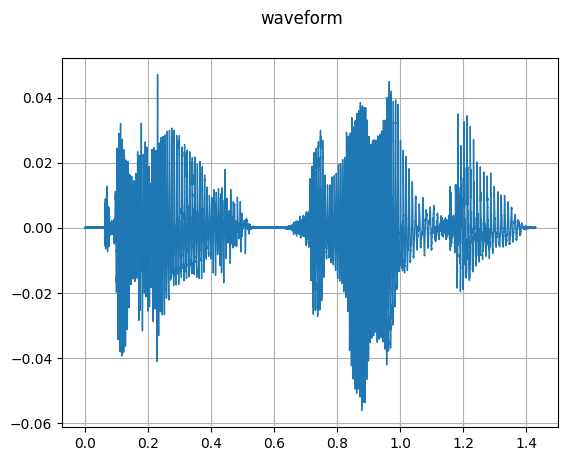

In [50]:
train_data.plot_waveform(5)

In [236]:
sample = next(iter(train_dataloader))

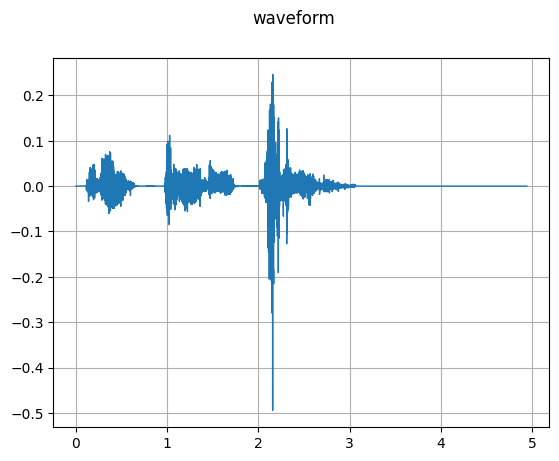

In [231]:
plot_waveform(sample[0][1], 16000)

In [212]:
play_audio(sample[0][1], 16000)